In [ ]:
!pip install 'aif360[LFR]'

In [ ]:
pip install fairlearn

In [ ]:
pip install scikit-lego

In [4]:
cd /usr/local/lib/python3.8/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.8/dist-packages/aif360/data/raw/german


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

In [175]:
import numpy as np
import pandas as pd
from aif360.datasets import GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from google.colab import files
import warnings
warnings.filterwarnings('ignore')


np.random.seed(0)

# Load dataset

In [176]:
dataset = load_preproc_data_german

In [339]:
# privileged = [{'sex': 1}]
# unprivileged = [{'sex': 0}]
# dataset_original = dataset(['sex'])

privileged = [{'age': 1}]
unprivileged = [{'age': 0}]
dataset_original = dataset(['age'])

scale_orig = StandardScaler()

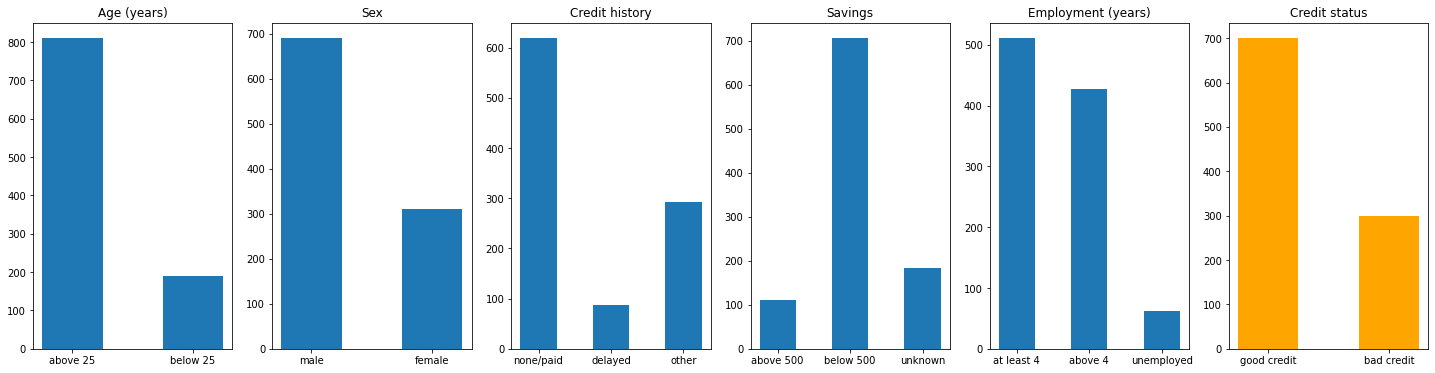

In [375]:
abv_25 = 0
bel_25 = 0

sex_m = 0
sex_f = 0

cred_good = 0
cred_del = 0
cred_oth = 0

sav_b500 = 0
sav_a500 = 0
sav_unk = 0

emp_lw = 0
emp_hi = 0
emp_na = 0

for i in range(len(dataset_original.features)):
  
  if dataset_original.features[i][0]==1:
    abv_25+=1
  elif dataset_original.features[i][0]==0:
    bel_25+=1

  if dataset_original.features[i][1]==1:
    sex_m+=1
  elif dataset_original.features[i][1]==0:
    sex_f+=1

  cred_good+=dataset_original.features[i][3]
  cred_del+=dataset_original.features[i][2]
  cred_oth+=dataset_original.features[i][4]

  sav_a500+=dataset_original.features[i][5]
  sav_b500+=dataset_original.features[i][6]
  sav_unk+=dataset_original.features[i][7]

  emp_lw+=dataset_original.features[i][8]
  emp_hi+=dataset_original.features[i][9]
  emp_na+=dataset_original.features[i][10]


g_cred = 0
b_cred = 0

for j in range(len(dataset_original.labels)):
  if dataset_original.labels[j][0]==1:
    g_cred+=1
  if dataset_original.labels[j][0]==2:
    b_cred+=1


plt.figure(figsize=(25,6))

plt.subplot(1,6,1)
plt.bar(['above 25', 'below 25'], [abv_25, bel_25], width=0.5)
plt.title('Age (years)')

plt.subplot(1,6,2)
plt.bar(['male', 'female'], [sex_m, sex_f], width=0.5)
plt.title('Sex')

plt.subplot(1,6,3)
plt.bar(['none/paid', 'delayed', 'other'], [cred_good, cred_del, cred_oth], width=0.5)
plt.title('Credit history')

plt.subplot(1,6,4)
plt.bar(['above 500', 'below 500', 'unknown'], [sav_a500, sav_b500, sav_unk], width=0.5)
plt.title('Savings')

plt.subplot(1,6,5)
plt.bar(['at least 4', 'above 4', 'unemployed'], [emp_lw, emp_hi, emp_na], width=0.5)
plt.title('Employment (years)')

plt.subplot(1,6,6)
plt.bar(['good credit', 'bad credit'], [g_cred, b_cred], color='orange', width=0.5)
plt.title('Credit status')

plt.show()

### Check base model performances based on accuracy and TPR difference (for fairness)

In [231]:
accuracies = {'SVC':[], 'RandomForestClassifier':[], 'KNeighborsClassifier':[], 'LogisticRegression':[], 'GaussianNB':[]}
fairness = {'SVC':[], 'RandomForestClassifier':[], 'KNeighborsClassifier':[], 'LogisticRegression':[], 'GaussianNB':[]}

model_list = [svm.SVC(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression(), GaussianNB()]

for i in range(500):

  train, test = dataset_original.split([0.8], shuffle=True)

  X_train = scale_orig.fit_transform(train.features)
  y_train = train.labels.ravel()

  X_test = scale_orig.transform(test.features) 
  y_test = test.labels.ravel()

  for mod in model_list:
    mod_try = mod
    try:
      mod_try.fit(X_train, y_train, sample_weight=train.instance_weights)
    except:
      mod_try.fit(X_train, y_train)
    predict_test = mod_try.predict(X_test)
    test_pred_try = test.copy()
    test_pred_try.labels = predict_test

    f_metric = ClassificationMetric(test, test_pred_try, unprivileged_groups=unprivileged, privileged_groups=privileged)

    accuracies[str(mod)[:-2]].append(round(f_metric.accuracy()*100,2))
    v1 = (2*f_metric.precision(privileged=False)*f_metric.recall(privileged=False))/(f_metric.precision(privileged=False)+f_metric.recall(privileged=False))
    v2 = (2*f_metric.precision(privileged=True)*f_metric.recall(privileged=True))/(f_metric.precision(privileged=True)+f_metric.recall(privileged=True))
    d = v1/v2
    fairness[str(mod)[:-2]].append(round(d,2))


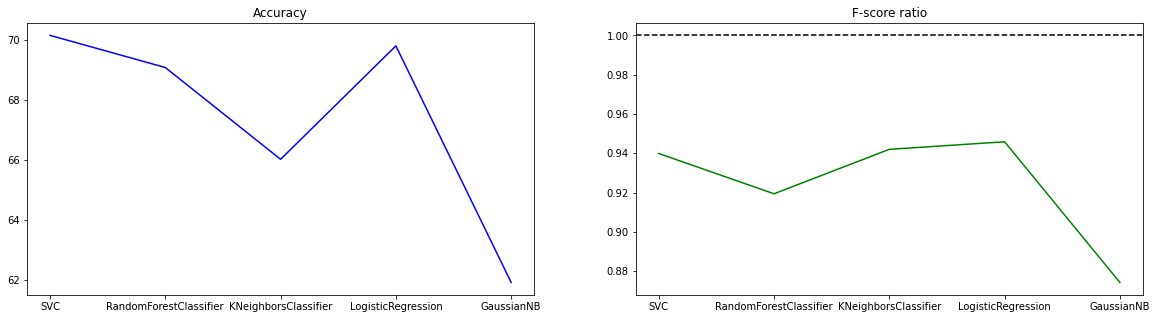

In [232]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(list(accuracies.keys()), [np.mean(x) for x in accuracies.values()], color='blue')
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(list(fairness.keys()), [np.mean(x) for x in fairness.values()], color='green')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.title('F-score ratio')

plt.show()

In [397]:
train, test = dataset_original.split([0.8], shuffle=True)
# print("training data size", train.features.shape)
# print("dataset feature names", train.feature_names)

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

X_test = scale_orig.transform(test.features) 
y_test = test.labels.ravel()

#### Logistic regression

In [299]:
C = [round(x,2) for x in np.linspace(0.01,1,20)]
class_weight = ['balanced', None]
multi_class = ['auto', 'ovr', 'multinomial']
penalty = ['l1','l2', 'elasticnet', None]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
n_jobs = [-1]
fit_intercept = [True, False]

grid_logreg = {'C': C, 'class_weight': class_weight, 'multi_class':multi_class,
               'penalty':penalty, 'solver':solver, 'n_jobs': n_jobs, 'fit_intercept': fit_intercept}

#### Support vector classifier

In [300]:
C = [round(x,2) for x in np.linspace(0.01,1,20)]
kernel = ['linear', 'poly', 'sigmoid', 'rbf']
gamma = ['scale', 'auto']+list(np.linspace(0.01,1,5))
class_weight = ['balanced', None]

grid_svc = {'C': C, 'kernel': kernel, 'gamma': gamma, 'class_weight': class_weight}

#### Find highest accuracy and fairness model parameters using *GridSearchCV*

In [301]:
def grid_search(model, params, scoring, X, Y):
  grid_mod = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scoring)
  grid_mod.fit(X,Y)
  
  return grid_mod

In [398]:
logreg_acc = grid_search(LogisticRegression(), grid_logreg, 'accuracy', X_train, y_train)
logreg_fr = grid_search(LogisticRegression(), grid_logreg, 'f1_weighted', X_train, y_train)

In [399]:
svc_acc = grid_search(svm.SVC(), grid_svc, 'accuracy', X_train, y_train)
svc_fr = grid_search(svm.SVC(), grid_svc, 'f1_weighted', X_train, y_train)

In [353]:
def try_model(mod_try, X, Y, x, tst, unprivileged, privileged, weights, color):

  mod_try.fit(X, Y, sample_weight=weights)
  predict_test = mod_try.predict(x)
  test_pred_try = tst.copy()
  test_pred_try.labels = predict_test

  f_metric = ClassificationMetric(tst, test_pred_try, unprivileged_groups=unprivileged, privileged_groups=privileged)

  print('Accuracy:',round(f_metric.accuracy()*100,2))
  v1 = (2*f_metric.precision(privileged=False)*f_metric.recall(privileged=False))/(f_metric.precision(privileged=False)+f_metric.recall(privileged=False))
  v2 = (2*f_metric.precision(privileged=True)*f_metric.recall(privileged=True))/(f_metric.precision(privileged=True)+f_metric.recall(privileged=True))
  # d = v1/v2
  print('Privileged class F-score:',round(v2,2))
  print('Unprivileged class F-score:',round(v1,2), end='\n\n')

  metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(tst.labels, test_pred_try.labels), display_labels = [1, 2]).plot(cmap=color)

#### Logistic regression

Accuracy: 72.5
Privileged class F-score: 0.84
Unprivileged class F-score: 0.77



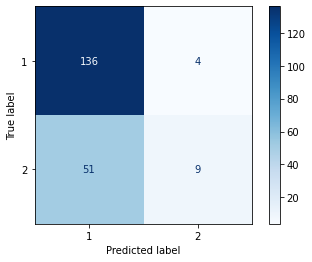

In [400]:
try_model(logreg_acc.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Blues')

Accuracy: 70.5
Privileged class F-score: 0.83
Unprivileged class F-score: 0.69



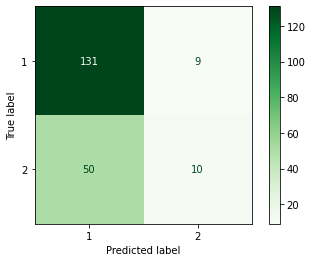

In [401]:
try_model(logreg_fr.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Greens')

#### SVC

Accuracy: 72.0
Privileged class F-score: 0.84
Unprivileged class F-score: 0.75



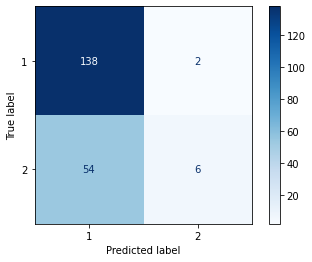

In [402]:
try_model(svc_acc.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Blues')

Accuracy: 64.0
Privileged class F-score: 0.76
Unprivileged class F-score: 0.38



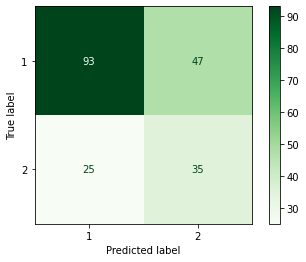

In [403]:
try_model(svc_fr.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Greens')

# Reweighing training dataset

In [404]:
reweighed = Reweighing(unprivileged_groups=unprivileged, privileged_groups=privileged)

train = reweighed.fit_transform(train)
test = reweighed.transform(test)

X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

X_test = scale_orig.transform(test.features) 
y_test = test.labels.ravel()

#### Logistic regression

Accuracy: 69.06
Privileged class F-score: 0.81
Unprivileged class F-score: 0.81



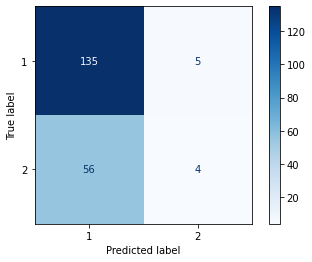

In [405]:
try_model(logreg_acc.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Blues')

Accuracy: 69.06
Privileged class F-score: 0.81
Unprivileged class F-score: 0.81



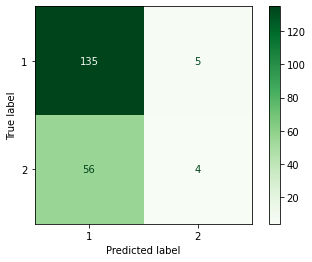

In [406]:
try_model(logreg_fr.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Greens')

#### SVC

Accuracy: 69.44
Privileged class F-score: 0.82
Unprivileged class F-score: 0.8



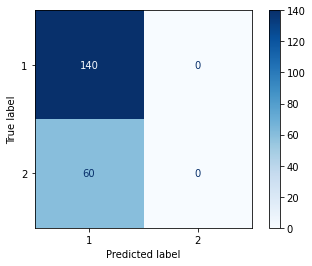

In [407]:
try_model(svc_acc.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Blues')

Accuracy: 65.13
Privileged class F-score: 0.75
Unprivileged class F-score: 0.65



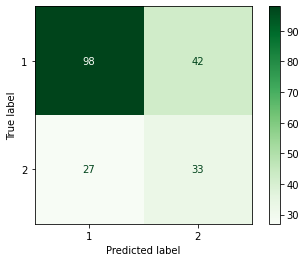

In [408]:
try_model(svc_fr.best_estimator_, X_train, y_train, X_test, test, unprivileged, privileged, train.instance_weights, 'Greens')